<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Demonstration of ML Training using Apache Spark MLlib </h1></div>
<div style="text-align:center"><h2><i>Random forest and Gradient-boosted trees</i></h2></div>
<div style="text-align:center"><h3><i>Author: Matteo Migliorini</i></h3></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

## This notebook is part of the Spark training delivered by CERN IT
### Classification with spark.ml

This notebook implements a system that performs classification of signal vs. background for high energy physics events using PySpark APIs, in particular `spark.ml`


In [ ]:
#
# Local mode: run this when using CERN SWAN not connected to a cluster 
#             or run it on a private Jupyter notebook instance
#             Dependency: PySpark (use SWAN or pip install pyspark)
#
# For CERN users: when using CERN SWAN connected to a cluster (analytix or cloud resources)
#                 do not run this but rather click on the (star) button


from pyspark.sql import SparkSession
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("ML HandsOn 1") \
        .config("spark.driver.memory","4g") \
        .config("spark.ui.showConsoleProgress", "false") \
        .getOrCreate()

In [2]:
spark

## Table of contents

* [Dataset description](#description)
* [Load the dataset](#load)
* [Feature preparation](#preparation)
* [Random Forest](#rf)
    * [Grid Search](#gridSearch)
* [Gradient-Boosting Trees](#gbt)

<a id=description></a><br>

## Dataset description

The dataset used in this example is the same used in [this paper](https://arxiv.org/pdf/1402.4735.pdf) and it has been produced using Monte Carlo simulations. It is a binary classification problem where the goal is to train a classifier able to distinguish between a *signal* process, the production of new theoretical Higgs bosons, and a *background* process with identical decay products but distinct kinematic features. <br>

Each row of this dataset contains 28 features plus the label:
* 21 *low-level features* which represent the basic measure made by the particle detector
    * Momentum of the observed paricles
    * Missing transverse momentum 
    * Jets and b-tagging information
* 7 *high-level features* computed from the low-level features that encode the knowledge of the different intermediate states of the two processes
    * Reconstructed invariant mass of the 

The dataset can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/HIGGS) (This version doesn't have the header) or found here `hdfs://analytix/Training/Spark/HiggsClassifier/Higgs10M.csv` .  

<a id=load></a><br>

## Load the dataset

As first a step we will load the sample dataset into a Spark dataframe infering the schema

In [5]:
# Local mode: read the data locally from the cloned repo
# there are only 10000 events in this sample dataset

data = "../data/Higgs10k.csv.gz"

# CERN users
# if you are connected to the Analytix cluster, you have access to the complete dataset
# the complete dataset has 10 milion data points.
# Uncomment this to read data from the anayltix cluster
# data = "hdfs://analytix/Training/Spark/HiggsClassifier/Higgs10M.csv"

df = (spark.read
      .format('csv')
      .option('header', 'true')
      .option('inferschema', 'true')
      .load(data)
     )


total_events = df.count()
print('There are',total_events,'events')

There are 10000 events


In [6]:
df.printSchema()

root
 |-- label: double (nullable = true)
 |-- lepton_pT: double (nullable = true)
 |-- lepton_eta: double (nullable = true)
 |-- lepton_phi: double (nullable = true)
 |-- missing_energy_magnitude: double (nullable = true)
 |-- missing_energy_phi: double (nullable = true)
 |-- jet1_pt: double (nullable = true)
 |-- jet1_eta: double (nullable = true)
 |-- jet1_phi: double (nullable = true)
 |-- jet1_b-tag: double (nullable = true)
 |-- jet2_pt: double (nullable = true)
 |-- jet2_eta: double (nullable = true)
 |-- jet2_phi: double (nullable = true)
 |-- jet2_b-tag: double (nullable = true)
 |-- jet3_pt: double (nullable = true)
 |-- jet3_eta: double (nullable = true)
 |-- jet3_phi: double (nullable = true)
 |-- jet3_b-tag: double (nullable = true)
 |-- jet4_pt: double (nullable = true)
 |-- je4_eta: double (nullable = true)
 |-- jet4_phi: double (nullable = true)
 |-- jet4_b-tag: double (nullable = true)
 |-- m_jj: double (nullable = true)
 |-- m_jjj: double (nullable = true)
 |-- m_lv: 

We can count how many events there are foreach class to see if the dataset is unbalanced

In [7]:
df.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|  0.0| 4705|
|  1.0| 5295|
+-----+-----+



As we can see the dataset seems to be balanced, hence we can split it into `train` and `test` dataframes.<br>
The fraction of  events used for the training stage is $0.9$ and the remainig $0.1$ will be used to test our classifier. In this way we will have approximately $1000$ events for the testing phase.

In [5]:
train, test = df.randomSplit([0.9,0.1])

In [6]:
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

2022-09-29 21:04:16,677 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Events for the training 9029
Events for the validation 971


<a id=visualization></a><br>

## Data visualization

We can plot some features to see how data are distributed with respect the two classes

In [7]:
import matplotlib.pyplot as plt 
from pyspark.sql.functions import col
%matplotlib notebook

def compute_hist(data, feature, target='label', n_bins=100, x_lim=[0,3]):
        
    ## Fix the range
    data = data.where((col(feature)<=x_lim[1]) &
                      (col(feature)>=x_lim[0]))
    
    sgn = data.where(col(target)==1.0) 
    bkg = data.where(col(target)==0.0)

    ## Compute the histograms
    bins_sgn, counts_sgn = sgn.select(feature).rdd.flatMap(lambda x: x).histogram(n_bins)
    bins_bkg, counts_bkg = bkg.select(feature).rdd.flatMap(lambda x: x).histogram(n_bins)
    
    return (bins_sgn, counts_sgn), (bins_bkg, counts_bkg)

<IPython.core.display.Javascript object>


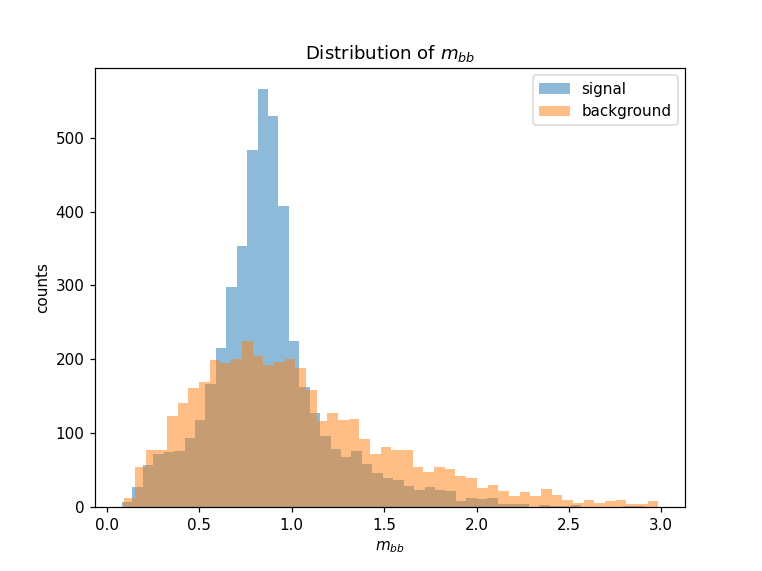

In [8]:
%matplotlib notebook

## hist is a touple containing bins and counts foreach bin
hist_signal, hist_bkg = compute_hist(data=train, feature='m_bb', target='label', n_bins=50, x_lim=[0,3])

f, ax = plt.subplots()
ax.hist(hist_signal[0][:-1], bins=hist_signal[0], weights=hist_signal[1], alpha=0.5, label='signal')
ax.hist(hist_bkg[0][:-1], bins=hist_bkg[0], weights=hist_bkg[1], alpha=0.5, label='background')
ax.set_xlabel('$m_{bb}$')
ax.set_ylabel('counts')
ax.set_title("Distribution of $m_{bb}$")
ax.legend()
plt.show()

<a id=preparation></a><br>

## Feature preparation

In this section we will prepare the input for the classifier. <br>
For the random forest we don't need to scale the features and encode the labels, we need only to create a `Dense Vector` containing the features.


In [9]:
from pyspark.ml.feature import VectorAssembler

feature = train.columns
feature.remove('label')

assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

This is how a single row of the features column looks like

In [10]:
train.select('features').take(1)

[Row(features=DenseVector([0.2758, -2.1077, 1.6889, 1.9085, 0.5887, 1.2632, 1.3635, -1.1625, 0.0, 0.5701, 0.6752, -0.7686, 0.0, 1.007, 1.5239, 1.5276, 0.0, 2.206, -0.4685, 0.2762, 3.102, 0.8865, 0.7056, 0.9947, 0.7695, 0.5959, 1.1519, 1.4402]))]

We can now plot the correlation matrix for the features 

In [11]:
from pyspark.ml.stat import Correlation

matrix = Correlation.corr(train.select('features'), 'features')
matrix_np = matrix.collect()[0]["pearson({})".format('features')].values

2022-09-29 21:04:52,271 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
2022-09-29 21:04:52,280 WARN netlib.InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/cvmfs/sft.cern.ch/lcg/views/LCG_102swan/x86_64-centos7-gcc11-opt/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<IPython.core.display.Javascript object>


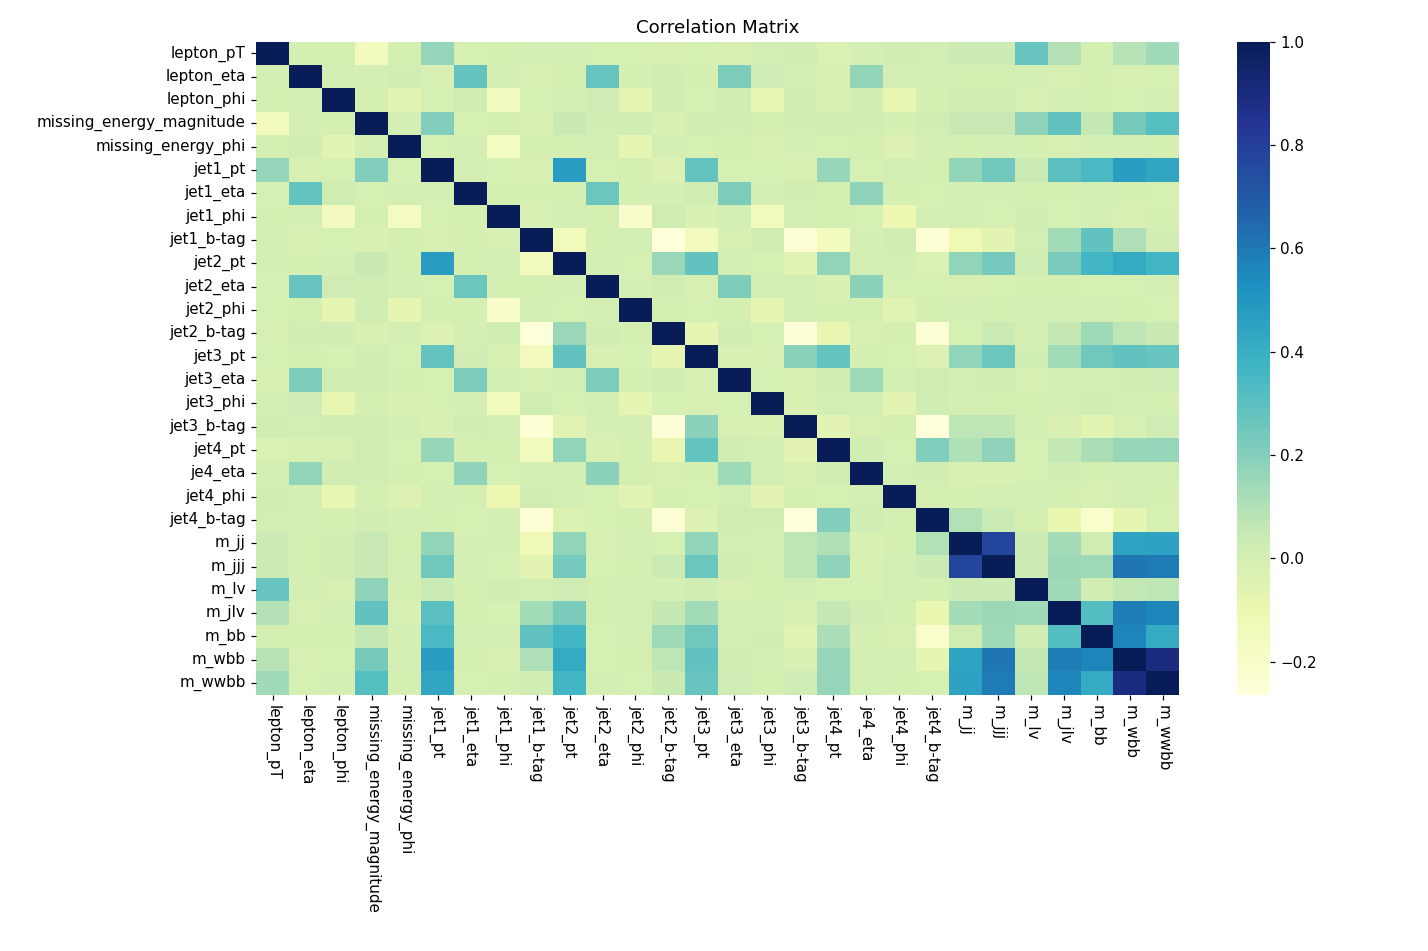

In [12]:
import seaborn as sns

matrix_np = matrix_np.reshape(len(feature),len(feature))

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.heatmap(matrix_np, cmap="YlGnBu")
ax.xaxis.set_ticklabels(feature, rotation=270)
ax.yaxis.set_ticklabels(feature, rotation=0)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

<a id=rf></a><br>

## Random Forest

**Random forest** are *ensemble learning* methos for classification and regression problems. In a Random forest we are combining  a large number of independent trees trained over random and equally distributed subsets of the data obtained by sampling with replacement the original dataset.

As a starting point we will train a simple random forest with $50$ trees, without tuning the hyperparameters. We need to specify the columns containing the features vector and the label.

In [13]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol='label', featuresCol='features', numTrees=50)

In [14]:
rf = rf.fit(train)

We can now use our trained model to predict the test instances

In [15]:
pred = rf.transform(test)

In [16]:
pred.select('label', 'prediction', 'probability').show(5)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.51219251921637...|
|  0.0|       1.0|[0.48525381949314...|
|  0.0|       0.0|[0.59682131025326...|
|  0.0|       0.0|[0.60709154528778...|
|  0.0|       0.0|[0.51579712022307...|
+-----+----------+--------------------+
only showing top 5 rows



Since the test dataset is small we can convert it into a pandas dataframe. This allows us to use `sklearn` and `matplotlib`.

In [17]:
pred_pd = pred.select(['label', 'prediction', 'probability']).toPandas()

In [18]:
pred_pd.head()

,label,prediction,probability
0,0.0,0.0,"[0.5121925192163791, 0.48780748078362096]"
1,0.0,1.0,"[0.4852538194931418, 0.5147461805068582]"
2,0.0,0.0,"[0.5968213102532699, 0.40317868974673005]"
3,0.0,0.0,"[0.6070915452877843, 0.3929084547122156]"
4,0.0,0.0,"[0.5157971202230772, 0.48420287977692283]"


We need to convert the column `prediction` into a list, because now it is of type `VectorDense`. We will create a new column `encoded_label` that we will use to plot the `roc curve`.

In [19]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_label'] = pred_pd['label'].map(lambda x: np.eye(2)[int(x)])

In [20]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_label'].tolist())

In [21]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

print('AUC: {:.3f}'.format(auc))

AUC: 0.745


<IPython.core.display.Javascript object>


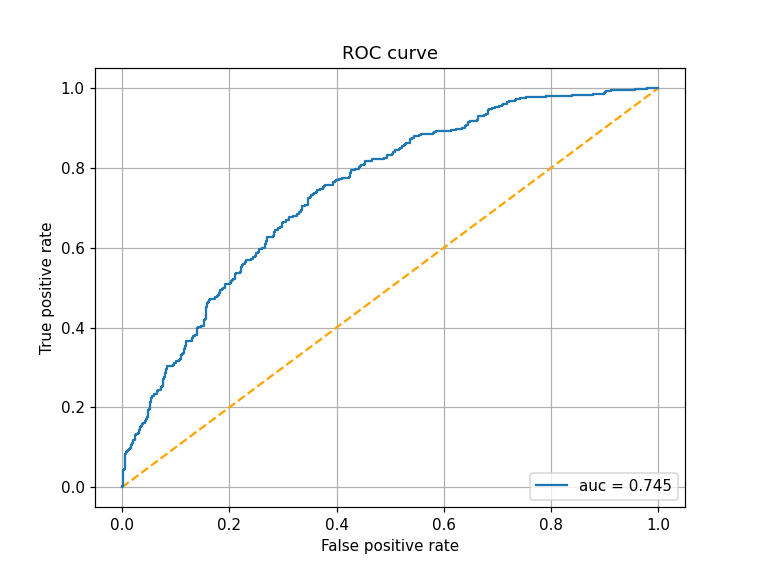

/tmp/ipykernel_983/2994592142.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


In [22]:
plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<a id=gridSearch></a><br>
### Grid Search

We can try to improve the performance of the classifier by tuning the hyperparameter such as the number of trees in the forest and the depth of each tree. <br>

First of all we will create a smaller sample of $\sim 80k$ for the grid search and cache it, because we will use it for different iterations.

In [23]:
subSample = train.sample(fraction=1.0/2, withReplacement=False).cache()
print('We will use',subSample.count(),' events for the grid search.')

We will use 4563  events for the grid search.


In this example we will perform a small grid search: in a real case a larger grid and more folds for the cross-validation should be used. We will now perform a search on a small grid, ideally you want to test more parameters and use more folds for the cross-validation.

In [24]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(labelCol='label', featuresCol='features', 
                            maxBins=20, subsamplingRate=0.7,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                            minInstancesPerNode=2)

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

paramGrid = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [10,20])\
  .addGrid(rf.numTrees, [50])\
  .build()

cv = CrossValidator(estimator=rf, 
                    evaluator=evaluator,
                    estimatorParamMaps=paramGrid,
                    numFolds=2, parallelism=2)

In [ ]:
bestModel = cv.fit(subSample)

It is possile to see the score obtained (in this case the AUC) for each set of parameters

In [26]:
print(zip(bestModel.avgMetrics, paramGrid))

We can get the parameter we are interested in and use them to train a random forest on the full dataset

In [27]:
print('BestModel:\n\t-maxDepth =',bestModel.bestModel._java_obj.getMaxDepth())
print('\t-numTrees =',bestModel.bestModel._java_obj.getNumTrees())

BestModel:
	-maxDepth = 10
	-numTrees = 50


A benefit of using ensemble methods (like Random Forest and Gradient Boosting) is that it is really easy to extract the importance scores of each attribute. As the name suggests, the importance of a feature indicates how usefull a feature was during the construction of the trees. The more an attribute is used to make decision within a tree, the higher its importance is.

<IPython.core.display.Javascript object>


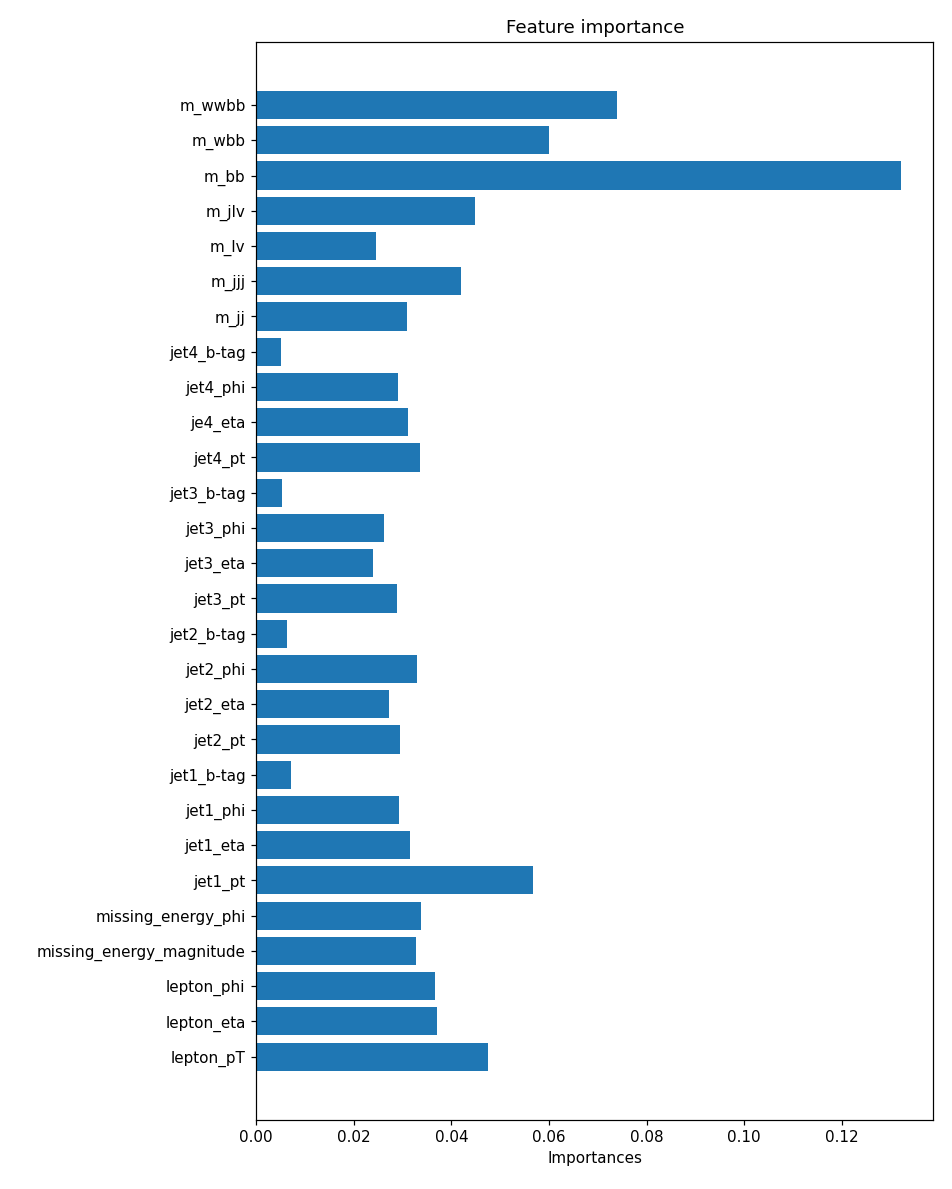

In [28]:
fig, ax = plt.subplots(figsize=(8,10))
ax.barh(range(28), bestModel.bestModel.featureImportances.toArray())
ax.set_yticks(range(28))
ax.set_yticklabels(feature)
ax.set_xlabel('Importances')
ax.set_title('Feature importance')
plt.tight_layout()
plt.show()

As one would expect the most important features are the *high-level* ones (because we are putting information inside them) and momentum of lepton, missing energy and leading jet. <br>

In [29]:
important_features = ['lepton_pT', 'missing_energy_magnitude',
                      'jet1_pt', 'jet2_pt',
                      'm_jlv', 'm_jj', 'm_jjj',
                      'm_bb', 'm_wbb', 'm_wwbb']

In [30]:
assembler = VectorAssembler(inputCols=important_features, outputCol='important_features')
train = assembler.transform(train)
test = assembler.transform(test)

In [31]:
rf_all = RandomForestClassifier(labelCol='label', featuresCol='important_features', 
                            numTrees=100, maxDepth=15,
                            maxBins=20, subsamplingRate=0.6,
                            minInfoGain= 1e-05,
                            featureSubsetStrategy='all',
                            minInstancesPerNode=2)

In [ ]:
%%time
model = rf_all.fit(train)

We can now save the model. It will be saved as a **parquet** file

In [33]:
model.write().overwrite().save(path='/tmp/rf_model')

2022-09-30 09:37:12,912 WARN scheduler.TaskSetManager: Stage 297 contains a task of very large size (4724 KiB). The maximum recommended task size is 1000 KiB.


and it is possible to reload it in the following way

In [34]:
from pyspark.ml.classification import RandomForestClassificationModel
loaded_rf = RandomForestClassificationModel\
        .load('/tmp/rf_model')

In [35]:
pred_full = loaded_rf.transform(test)

In [36]:
pred_pd_full = pred_full.select(['label', 'prediction', 'probability']).toPandas()

2022-09-30 09:37:46,023 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 10.0 MiB


In [37]:
pred_pd_full['probability'] = pred_pd_full['probability'].map(lambda x: list(x))
pred_pd_full['encoded_label'] = pred_pd_full['label'].map(lambda x: np.eye(2)[int(x)])

y_pred = np.array(pred_pd_full['probability'].tolist())
y_true = np.array(pred_pd_full['encoded_label'].tolist())

<IPython.core.display.Javascript object>


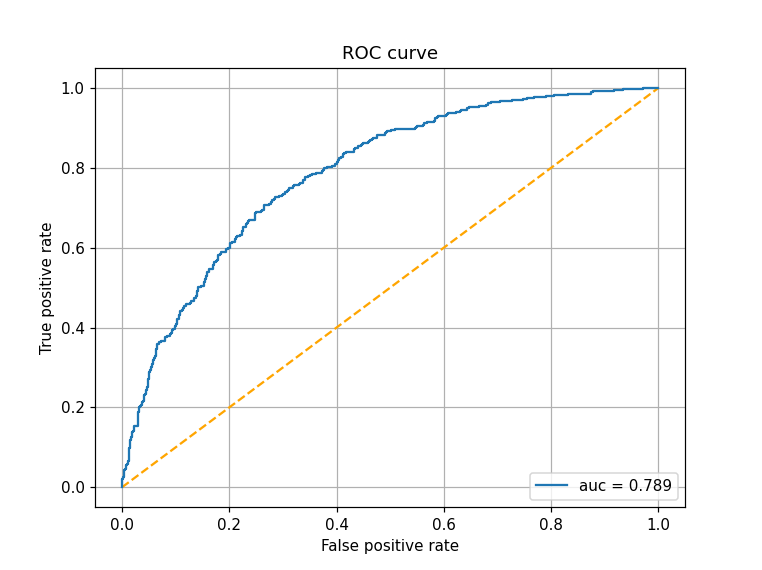

/tmp/ipykernel_983/1969845959.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


In [39]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, threshold = roc_curve(y_score=y_pred[:,0], y_true=y_true[:,0])
auc = auc(fpr, tpr)

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr, tpr, label='auc = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

<a id=gbt></a><br>
## Gradient-Boosting Trees

Like Random Forest, Gradient Boosting Trees is a machine learning technique which produces a prediction model in the form of an ensemble of of weak prediction trees. Unlike random forest, GBT optimize a cost function over a function space by iteratively choosing a function that points in the negative gradient direction.

The pipeline in spark is the same of the random forest, it is sufficient to substitute `RandomForestClassifier` with `GBTClassifier`.   

In [40]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10)

In [ ]:
%%time
gbt_model = gbt.fit(train)

In [46]:
pred_gbt = gbt_model.transform(test)

In [47]:
pred_pd_gbt = pred_gbt.select(['label', 'prediction', 'probability']).toPandas()

2022-09-30 09:41:15,733 WARN scheduler.DAGScheduler: Broadcasting large task binary with size 5.5 MiB


In [48]:
pred_pd_gbt['probability'] = pred_pd_gbt['probability'].map(lambda x: list(x))
pred_pd_gbt['encoded_label'] = pred_pd_gbt['label'].map(lambda x: np.eye(2)[int(x)])

y_pred_gbt = np.array(pred_pd_gbt['probability'].tolist())
y_true_gbt = np.array(pred_pd_gbt['encoded_label'].tolist())

<IPython.core.display.Javascript object>


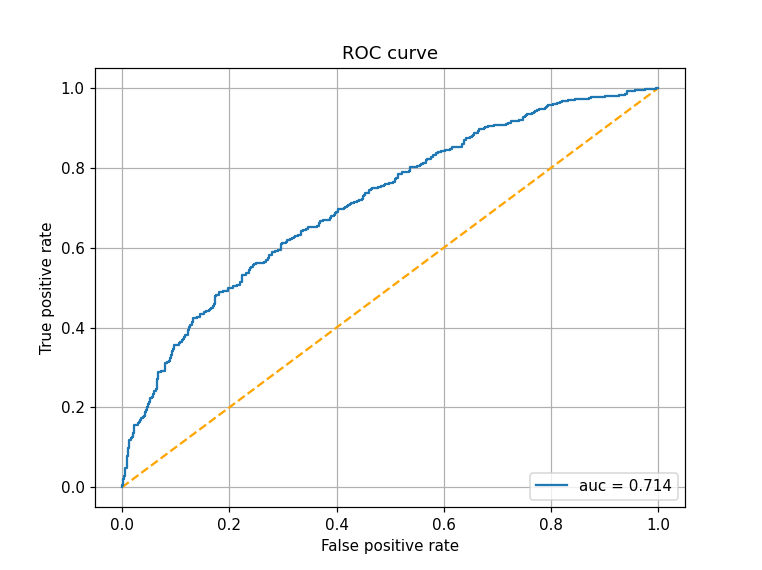

/tmp/ipykernel_983/75780641.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0,1], [0,1], 'k--', color='orange')


In [49]:
from sklearn.metrics import auc, roc_curve
fpr_gbt, tpr_gbt, threshold_gbt = roc_curve(y_score=y_pred_gbt[:,0], y_true=y_true_gbt[:,0])
auc_gbt = auc(fpr_gbt, tpr_gbt)

plt.figure()
plt.plot([0,1], [0,1], 'k--', color='orange')
plt.plot(fpr_gbt, tpr_gbt, label='auc = {:.3f}'.format(auc_gbt))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [50]:
spark.stop()